# **Messenger conversation analysis**

This notebook illustrates the usage of the `conversation_analysis` package to analyze an example messenger conversation archive in JSON format. It covers most of the functionality of the package, which can be dvided in three parts:
- Loading `Conversation`s from files,
- Analyzing the conversation's data,
- Plotting analysis results.

The dummy conversation used in this notebook has been made using with the script `../scripts/dummy_messenger_json.py`. The contents of a genuine conversation have been modified using the free 60k lemmas available [here](https://www.wordfrequency.info/samples.asp).


Contents
--------
1. [Listing and loading conversations](#listing_loading)
2. [Message data extraction and statistics](#message_stats)
    1. [Global sum statistics](#global_sum)
    2. [Binned sum statistics](#binned_sum)
    3. [Rolling sum statistics](rolling_sum)
    4. [Word count](#word_count)
3. [Working with reactions data](#reaction_stats)
4. [Extracting media information](#media_info)
5. [Filtering messages](#filtering)

In [1]:
import sys
import os
from pathlib import Path

# set the module directory in sys.path
pdir = Path(os.path.abspath("")).resolve().parent
if not (cdir := str(pdir)) in sys.path:
    sys.path.append(cdir)

## <a name="listing_loading"></a>Listing and loading conversations

Archives of Messenger conversations appear as a file tree, with the conversation data actually contained in a folder "inbox". Conversation archives may be split in multiple directories, for instance when archiving on a yearly basis. The function `list_messenger_conversations` recovers all distinct conversations from multiple file archives.

In [2]:
from conversation_analysis import list_messenger_conversations, MessengerConversation

archive_dir = pdir / 'examples/Messenger_JSON_archive'
conversations = list_messenger_conversations(archive_dir, return_relative_path=True)
conversations

{'conversation1_bhmqhe56cg': ['facebook-yourname31415927_1/messages/inbox/conversation1_bhmqhe56cg',
  'facebook-yourname31415927_2/messages/inbox/conversation1_bhmqhe56cg'],
 'conversation2_kaopxbamlx': ['facebook-yourname31415927_1/messages/inbox/conversation2_kaopxbamlx']}

In our example, archive is split in two directories, and contains two conversations:
- "conversation1_bhmqhe56cg" present in both archive folders,
- "conversation2_kaopxbamlx" present only in the first.

Note that conversations have names of the form "\<conv_name\>_\<random_chars\>". A `MessengerConversation` can be instanciated from the list of conversation directories thus obtained. Here, relative paths are kept to avoid displaying irrelevant absolute path structure so the conversation paths given must be reconstructed before doing so. More conveniently, setting the parameter `return_relative_path=False` (the default) yields absolute paths.

In [3]:
conv_paths = [archive_dir / p for p in conversations['conversation1_bhmqhe56cg']]
# For your application it might be more useful to set resolve_uri to True (the default)
# which resolves the uri of the media in the conversation.
conv = MessengerConversation.from_facebook_json(conv_paths, resolve_uri=False)

Our conversation could have a participant named `"Facebook User"`. This name is given to any participant that has left the conversation. Participants names can be changed with the method `replace_participants`.

As a side note, there is also the possibility that a participant deletes his/her Facebook account, in this case the name is changed to `""` (the empty string).

In [4]:
# conv.replace_participants({'Facebook User': "John Doe"})
conv.participants

{'Ada lovelace': 0,
 'Al-Jazari': 1,
 'Alan Turing': 2,
 'Alonzo Church': 3,
 'Charles Babbage': 4,
 'Claude Shannon': 5,
 'Dennis Richie': 6,
 'Edsger Dijkstra': 7,
 'Frances Elizabeth Allen': 8,
 'George Boole': 9,
 'Grace Hopper': 10,
 'Haskell Curry': 11,
 'Ida Rhodes': 12,
 'John von Neumann': 13,
 'Joseph-Marie Jacquard': 14,
 'Lynn Conway': 15,
 'Stephen Cole Kleene': 16}

## <a name="message_stats"></a>Message data extraction from a conversation and statistics computation

The analysis of the conversation's content revolves around the manipulation of `pandas.DataFrame`s to compute relevant quatities. The conversation's messages data is returned by the method `Conversation.messages_data`. It can be used directly to instanciate a `ConversationStats` object (defined in the `analysis` module), which is essentially a container for a `pandas.DataFrame`. The class implements 3 data analysis methods that return a formatted dataframe for further analysis:
- `ConversationStats.sum`: sum the quantities,
- `ConversationStats.binned_sum`: sum the quantities in distinct time bins,
- `ConversationStats.rolling_sum`: compute a rolling window sum.

`ConversationStats` is directly adapted to process message data. However, some modifications are required to adapt it to reactions statistics. This will be covered in the next section.

In [5]:
from conversation_analysis import ConversationStats
messages_data = conv.messages_data()
messages_data

{'timestamp': array([1.48322109e+09, 1.48323151e+09, 1.48325670e+09, ...,
        1.52487023e+09, 1.52487044e+09, 1.52487975e+09]),
 'sender': array(['John von Neumann', 'Lynn Conway', 'Al-Jazari', ..., 'Al-Jazari',
        'Alonzo Church', 'Claude Shannon'], dtype='<U23'),
 'has_content': array([1, 1, 1, ..., 1, 1, 1]),
 'nb_words': array([ 5,  1,  3, ...,  8,  4, 24]),
 'nb_chars': array([ 15,   5,  19, ...,  39,  14, 117]),
 'nb_reactions': array([0, 0, 0, ..., 0, 0, 0]),
 'nb_photos': array([0, 0, 0, ..., 0, 0, 0]),
 'nb_videos': array([0, 0, 0, ..., 0, 0, 0]),
 'nb_audio': array([0, 0, 0, ..., 0, 0, 0]),
 'nb_gifs': array([0, 0, 0, ..., 0, 0, 0]),
 'has_shared': array([0, 0, 0, ..., 0, 0, 0])}

In [6]:
timestamp = messages_data.pop('timestamp')
group = messages_data.pop('sender')

# the dataframe is multi-indexed by the datetime attributes of the message publication timestamp
messages_stats = ConversationStats(timestamp, group, data=messages_data)
messages_stats.dataframe

_group  \
year month day hour minute second microsecond month_name day_name timestamp                                         
2016 12    31  21   51     28     84000       12 - Dec   6 - Sat  2016-12-31 21:51:28.084000111  John von Neumann   
2017 1     1   0    45     9      154000      01 - Jan   0 - Sun  2017-01-01 00:45:09.154000044       Lynn Conway   
               7    45     1      743999      01 - Jan   0 - Sun  2017-01-01 07:45:01.743999958         Al-Jazari   
               8    7      35     414999      01 - Jan   0 - Sun  2017-01-01 08:07:35.414999962   Charles Babbage   
               9    10     10     492000      01 - Jan   0 - Sun  2017-01-01 09:10:10.492000103         Al-Jazari   
...                                                                                                           ...   
2018 4     27  22   34     47     475000      04 - Apr   5 - Fri  2018-04-27 22:34:47.475000143     Alonzo Church   
                    53     51     169000      04 - Apr   5 - Fri  2018-04-27 22:53:51.169000149     Alonzo Church   
               23   3      48     861000      04 - Apr   5 - Fri  2018-04-27 23:03:48.861000061         Al-Jazari   
                    7      15     403000      04 - Apr   5 - Fri  2018-04-27 23:07:15.403000116     Alonzo Church   
           28  1    42     33     588000      04 - Apr   6 - Sat  2018-04-28 01:42:33.588000059    Claude Shannon   

                                                                                                 has_content  \
year month day hour minute second microsecond month_name day_name timestamp                                    
2016 12    31  21   51     28     84000       12 - Dec   6 - Sat  2016-12-31 21:51:28.084000111            1   
2017 1     1   0    45     9      154000      01 - Jan   0 - Sun  2017-01-01 00:45:09.154000044            1   
               7    45     1      743999      01 - Jan   0 - Sun  2017-01-01 07:45:01.743999958            1   
               8    7      35     414999      01 - Jan   0 - Sun  2017-01-01 08:07:35.414999962            1   
               9    10     10     492000      01 - Jan   0 - Sun  2017-01-01 09:10:10.492000103            1   
...                                                                                                      ...   
2018 4     27  22   34     47     475000      04 - Apr   5 - Fri  2018-04-27 22:34:47.475000143            1   
                    53     51     169000      04 - Apr   5 - Fri  2018-04-27 22:53:51.169000149            1   
               23   3      48     861000      04 - Apr   5 - Fri  2018-04-27 23:03:48.861000061            1   
                    7      15     403000      04 - Apr   5 - Fri  2018-04-27 23:07:15.403000116            1   
           28  1    42     33     588000      04 - Apr   6 - Sat  2018-04-28 01:42:33.588000059            1   

                                                                                                 nb_words  \
year month day hour minute second microsecond month_name day_name timestamp                                 
2016 12    31  21   51     28     84000       12 - Dec   6 - Sat  2016-12-31 21:51:28.084000111         5   
2017 1     1   0    45     9      154000      01 - Jan   0 - Sun  2017-01-01 00:45:09.154000044         1   
               7    45     1      743999      01 - Jan   0 - Sun  2017-01-01 07:45:01.743999958         3   
               8    7      35     414999      01 - Jan   0 - Sun  2017-01-01 08:07:35.414999962         9   
               9    10     10     492000      01 - Jan   0 - Sun  2017-01-01 09:10:10.492000103         4   
...                                                                                                   ...   
2018 4     27  22   34     47     475000      04 - Apr   5 - Fri  2018-04-27 22:34:47.475000143         5   
                    53     51     169000      04 - Apr   5 - Fri  2018-04-27 22:53:51.169000149         2   
               23   3      48     8610

### <a name="global_sum"></a>Global sum statistics

Global sum statistics are obtained with the method `ConversationStats.sum`. The returned dataframe is indexed by each participant (or group) with the sum of each quantity corresponding to this participant as columns.

The data obtained in this form can be represented as pie plots with the function `pie_plot`.

In [7]:
from conversation_analysis import pie_plot

# timespan selects only those messages which post date t is
# 2017-02-03 14:52:38.004568 <= t < 2018-04-01 00:00:00.0
df = messages_stats.sum(timespan=((2017, 2, 3, 14, 52, 38, 4568), (2018, 4)))
# select columns with non-zero counts
participants_stats_df = df.loc[:, ['has_content', 'nb_words', 'nb_chars', 'nb_reactions', 'nb_photos']]
participants_stats_df

,has_content,nb_words,nb_chars,nb_reactions,nb_photos
_group,,,,,
Ada lovelace,2758,15245,75115,179,113
Al-Jazari,2435,17087,84548,192,15
Alan Turing,275,1874,9343,27,7
Alonzo Church,3216,32425,162028,239,23
Charles Babbage,486,5549,27888,49,15
Claude Shannon,860,8732,43879,56,29
Dennis Richie,671,8981,45263,102,13
Edsger Dijkstra,91,756,3767,24,2
Frances Elizabeth Allen,1672,16102,81026,143,62


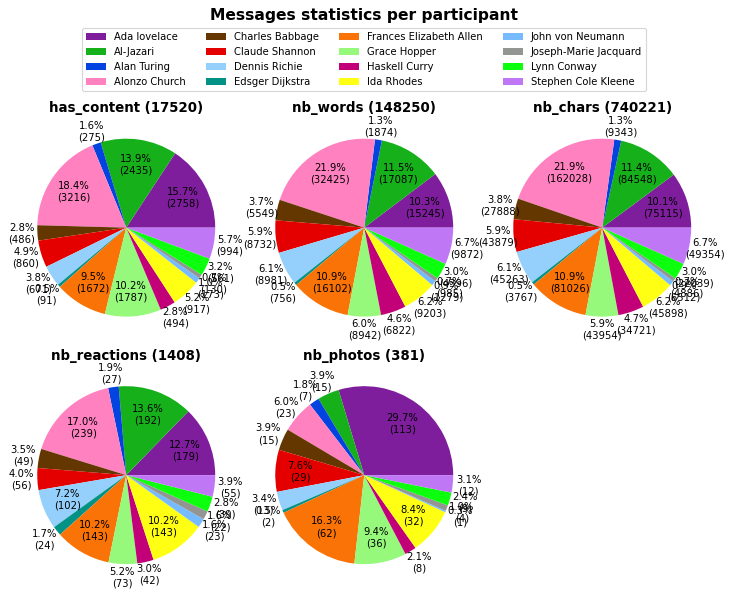

In [8]:
fig, axs = pie_plot(participants_stats_df, legend_kw={'bbox_to_anchor': (0.5, 0.96)}, dpi=80)
_ = fig.suptitle("Messages statistics per participant",
                 y=0.985, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/msg_pc_participant.png") # 'pc' stands for pie chart

The individual particpant counts can be further aggregated into groups. An interesting application is the aggregation by gender.

In [9]:
genders = {
    'Ada lovelace': 'female',
    'Al-Jazari': 'male',
    'Alan Turing': 'male',
    'Alonzo Church': 'male',
    'Charles Babbage': 'male',
    'Claude Shannon': 'male',
    'Dennis Richie': 'male',
    'Edsger Dijkstra': 'male',
    'Frances Elizabeth Allen': 'female',
    'George Boole': 'male',
    'Grace Hopper': 'female',
    'Haskell Curry': 'male',
    'Ida Rhodes': 'female',
    'John Doe': 'male',
    'John von Neumann': 'male',
    'Joseph-Marie Jacquard': 'male',
    'Lynn Conway': 'female',
    'Stephen Cole Kleene': 'male'
    }
df = messages_stats.sum(groups=genders, timespan=None)
gender_stats_df = df.loc[:, ['has_content', 'nb_words', 'nb_chars', 'nb_reactions', 'nb_photos']]
gender_stats_df

,has_content,nb_words,nb_chars,nb_reactions,nb_photos
_group,,,,,
female,8785,60777,302429,577,285
male,11275,109336,547074,831,150


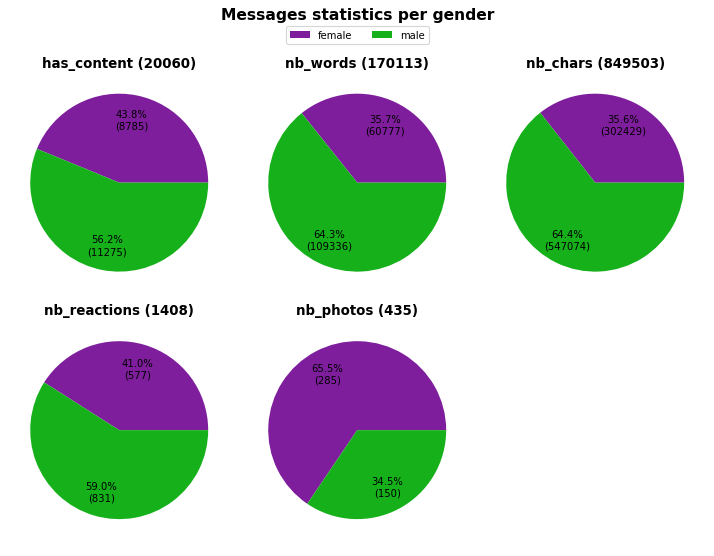

In [10]:
fig, axs = pie_plot(gender_stats_df, legend_kw={'bbox_to_anchor': (0.5, 0.96)}, dpi=80)
_ = fig.suptitle("Messages statistics per gender",
                 y=0.985, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/msg_pc_gender.png")

### <a name="binned_sum"></a>Binned sum statistics

Binned count statistics are obtained with the method `ConversationStats.binned_sum`. The principle is the same as the global count, except that the values are summed separately for each value of the binning entry. For instance, when selecting `"hour"` as the binning entry, the result will be the sum of the different columns for each hour and for each group. The data is now indexed by the binning values, and the participant/group information is stored in a column multi-index (quantity, group).

A tuple of binning entries can be selected among `{"year", "month", "day", "hour", "minute", "second", "microsecond", "month_name", "day_name", "timestamp"}`.

The data obtained in this form can be represented as a bar plot with the function `bar_plot`.

In [11]:
# Aggregate by genders to display the whole dataframe
df = messages_stats.binned_sum(binning_entries=('hour',), groups=genders, timespan=None)
df

quantity has_content       has_shared      nb_audio      nb_chars         \
group         female  male     female male   female male   female   male   
hour                                                                       
0                 92   207          0    0        0    0     4041  11194   
1                 61   119          0    0        0    0     2738   5690   
2                 40    85          0    0        0    0     1278   4810   
3                 38    74          0    0        0    0     1225   4589   
4                 43    83          0    0        0    0     1911   6021   
5                 92   127          0    0        0    0     2942   7493   
6                166   163          0    0        0    0     5447   7292   
7                299   225          0    0        0    0    10376  10290   
8                361   298          0    0        0    0    14378  16701   
9                355   319          0    0        0    0    13708  15906   
10               419   380          0    0        0    0    15265  19379   
11               449   387          0    0        0    0    15172  17997   
12               526   465          0    0        0    0    18555  22504   
13               533   474          0    0        0    0    18079  22572   
14               593   617          0    0        0    0    20039  31185   
15               647   702          0    0        0    0    19339  34439   
16               613   890          0    0        0    0    20109  43629   
17               666   998          0    0        0    0    23695  48420   
18               706  1144          0    0        0    0    24545  54752   
19               634  1075          0    0        0    0    20384  47768   
20               523   891          0    0        0    0    16277  38682   
21               439   688          0    0        0    0    16240  30552   
22               318   527          0    0        0    0    10309  26423   
23               172   337          0    0        0    0     6377  18786   

quantity nb_gifs      nb_photos      nb_reactions      nb_videos       \
group     female male    female male       female male    female male   
hour                                                                    
0              0    0         6    3           16    8         0    0   
1              0    0         4    2            3    4         0    0   
2              0    0         0    1            1    2         0    0   
3              0    0         1    3            2    3         0    0   
4              0    0         2    1            2    2         0    0   
5              0    0         6    2            6   14         0    0   
6              0    0         8    5           19   23         0    0   
7              0    0        10    4           11   14         0    0   
8              0    0        10    5           44   29         0    0   
9              0    0        14    3           24   21         0    0   
10             0    0        15    6           36   43         0    0   
11             0    0        11    8           30   34         0    0   
12             0    0        19    6           37   42         0    0   
13             0    0        26    8           33   42         0    0   
14             0    0        24   10           36   56         0    0   
15             0    0        18   15           39   47         0    0   
16             0    0        20    8           33   65         0    0   
17             0    0        20    9           33   78         0    0   
18             0    0        13   13           37   84         0    0   
19             0    0        17   12           40   76         0    0   
20             0    0        12    9           31   59         0    0   
21             0    0         8    8           20   44         0    0   
22             0    0        16    6           32   24         0    0   
23             0    0         5    3           12

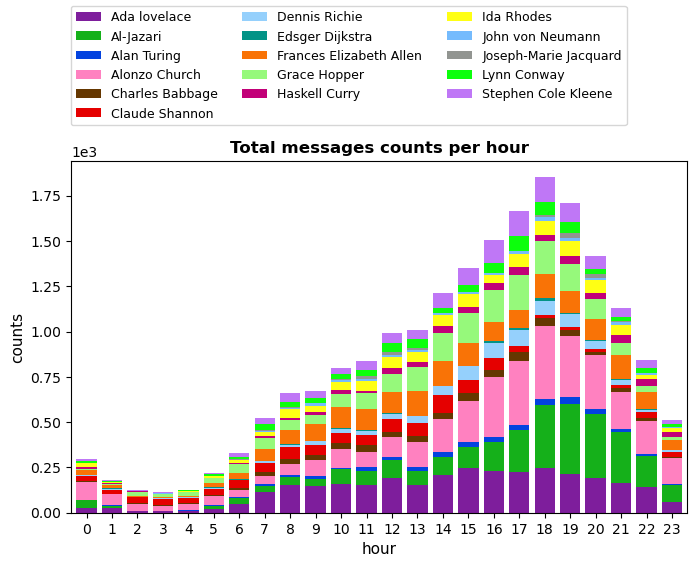

In [12]:
from conversation_analysis import bar_plot

df = messages_stats.binned_sum(binning_entries=('hour',), groups=None, timespan=None)
fig, ax = bar_plot(df['has_content'], print_percents=False, dpi=100)
_ = ax.set_title("Total messages counts per hour", fontweight='bold')
# fig.savefig("./figures and data/msg_participants_bp_hour.png") # 'bp' stands for bar plot

### <a name="rolling_counts"></a>Rolling counts statistics

Rolling sum statistics are obtained with the method `ConversationStats.rolling_sum`. It can be viewed as a continuous form of binned count. Here, the column structure is the same as for binned counts, that is a multi-index (quantity, group). The function aggregates the rows according to a specified granularity `sampling_freq`, for instance `'5D'` (a frequency string mapping to a pandas [`DateOffset`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) object) before windowing. The resulting index is similar to that of the original dataframe, with steps corresponding to the granularity.

Such data can be represented as a stack plot with the function `stack_plot`.

In [13]:
# Aggregate by genders to display the whole dataframe
df = messages_stats.rolling_sum(sampling_freq='5D', window_size=10,
                                win_type='gaussian', win_args={'std': 2},
                                period=None, groups=genders, timespan=None)
df

quantity                                                          has_content  \
group                                                                  female   
year month day hour minute second microsecond timestamp                         
2016 12    30  0    0      0      0           1483056000000000000  167.285791   
2017 1     4   0    0      0      0           1483488000000000000  179.851357   
           9   0    0      0      0           1483920000000000000  180.762834   
           14  0    0      0      0           1484352000000000000  169.384456   
           19  0    0      0      0           1484784000000000000  147.513309   
...                                                                       ...   
2018 4     9   0    0      0      0           1523232000000000000   42.700611   
           14  0    0      0      0           1523664000000000000   43.277100   
           19  0    0      0      0           1524096000000000000   45.063752   
           24  0    0      0      0           1524528000000000000   45.870444   
           29  0    0      0      0           1524960000000000000   44.714926   

quantity                                                                       \
group                                                                    male   
year month day hour minute second microsecond timestamp                         
2016 12    30  0    0      0      0           1483056000000000000  178.461355   
2017 1     4   0    0      0      0           1483488000000000000  190.307818   
           9   0    0      0      0           1483920000000000000  193.948890   
           14  0    0      0      0           1484352000000000000  189.437731   
           19  0    0      0      0           1484784000000000000  181.731588   
...                                                                       ...   
2018 4     9   0    0      0      0           1523232000000000000   78.123240   
           14  0    0      0      0           1523664000000000000   91.245128   
           19  0    0      0      0           1524096000000000000  103.605319   
           24  0    0      0      0           1524528000000000000  110.531523   
           29  0    0      0      0           1524960000000000000  111.071505   

quantity                                                          has_shared  \
group                                                                 female   
year month day hour minute second microsecond timestamp                        
2016 12    30  0    0      0      0           1483056000000000000        0.0   
2017 1     4   0    0      0      0           1483488000000000000        0.0   
           9   0    0      0      0           1483920000000000000        0.0   
           14  0    0      0      0           1484352000000000000        0.0   
           19  0    0      0      0           1484784000000000000        0.0   
...                                                                      ...   
2018 4     9   0    0      0      0           1523232000000000000        0.0   
           14  0    0      0      0           1523664000000000000        0.0   
           19  0    0      0      0           1524096000000000000        0.0   
           24  0    0      0      0           1524528000000000000        0.0   
           29  0    0      0      0           1524960000000000000        0.0   

quantity                                                                \
group                                                             male   
year month day hour minute second microsecond timestamp                  
2016 12    30  0    0      0      0           1483056000000000000  0.0   
2017 1     4   0    0      0      0           1483488000000000000  0.0   
           9   0    0      0      0           1483920000000000000  0.0   
           14  0    0      0      0           1484352000000000000  0.0   
           19  0    0      0      0           1484784000000000000  0.0   
...              

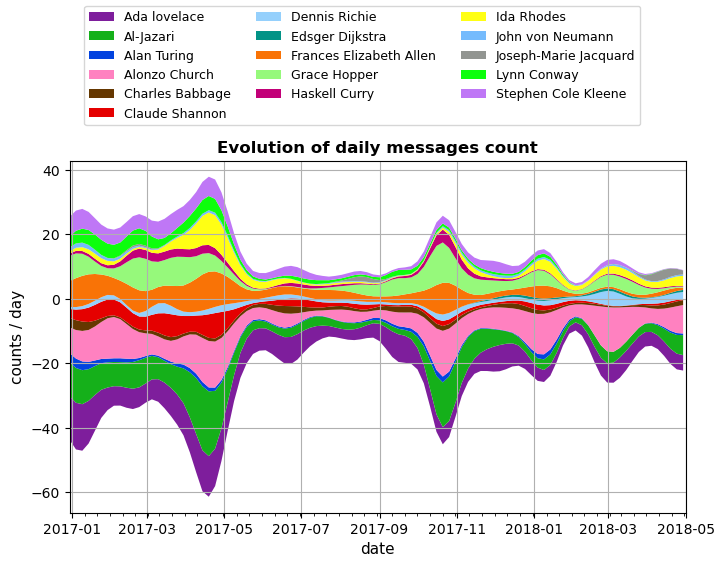

In [14]:
from conversation_analysis import stack_plot

df = messages_stats.rolling_sum(sampling_freq='5D', window_size=10,
                                win_type='gaussian', win_args={'std': 2},
                                period=None, groups=None, timespan=None)
fig, ax = stack_plot(df['has_content'], baseline='wiggle',
                     timescale='day', xlabel_strftime='%Y-%m', dpi=100)
_ = ax.set_title('Evolution of daily messages count', fontweight='bold')
# fig.savefig("./figures and data/msg_sp_participants_whole.png") # 'sp' stands for stack plot

It is also possible to aggregate the data over a given period. {"year", "month", "day", "hour", "minute", "second"}
Note that the y-axis shows the counts/time unit summed over the whole timespan.

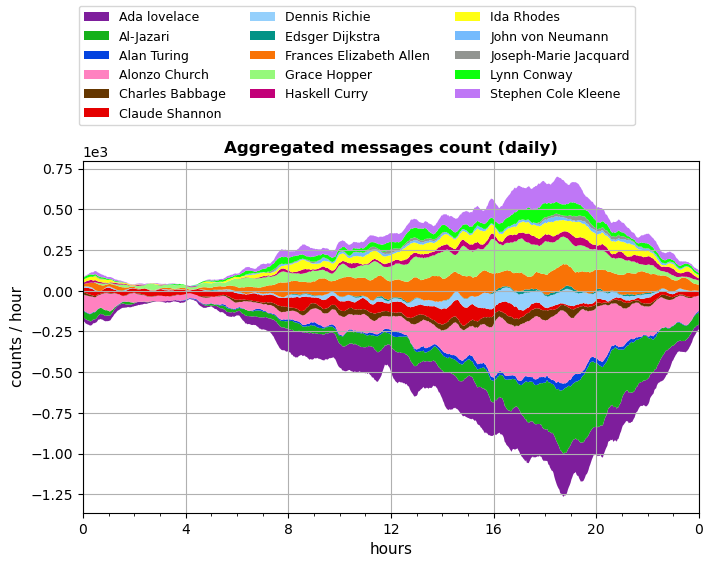

In [15]:
df = messages_stats.rolling_sum(sampling_freq='2min', window_size=15,
                                  win_type='gaussian', win_args={'std': 5},
                                  period='day', groups=None, timespan=None)
fig, ax = stack_plot(df['has_content'], baseline='wiggle', timescale='hour', dpi=100)
_ = ax.set_title('Aggregated messages count (daily)', fontweight='bold')
# fig.savefig("./figures and data/msg_sp_participants_hourly.png")

### <a name="word_count"></a>Word count

The conversation words count is obtained with the method `word_counts`. It takes the form of a mapping: group -> Counter, that can be converted to a `pandas.DataFrame` with the function `word_count_dataframe`. The structure of the dataframe makes it possible to plot with `pie_plot`.

In [16]:
from conversation_analysis import word_count_dataframe

wd_counts = conv.word_counts(groups=None, casefold=True, remove_diacritics=True)
words = ['road', 'parameter', 'astronaut', 'media', 'strongly', 'call']
word_count_df = word_count_dataframe(wd_counts, words)
word_count_df

counts,road,parameter,astronaut,media,strongly,call
group,,,,,,
Ada lovelace,33,1,2,34,3,152
Al-Jazari,48,6,2,47,8,169
Alan Turing,7,0,0,4,1,19
Alonzo Church,54,10,3,62,10,328
Charles Babbage,19,0,0,10,2,54
Claude Shannon,24,0,2,24,3,82
Dennis Richie,20,3,0,15,5,90
Edsger Dijkstra,0,0,0,2,1,11
Frances Elizabeth Allen,40,3,1,32,6,151


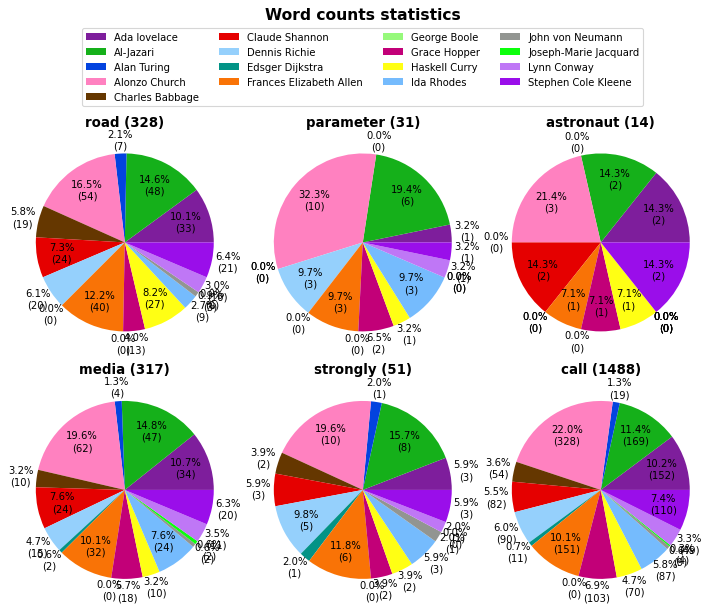

In [17]:
fig, axs = pie_plot(word_count_df, legend_kw={'bbox_to_anchor': (0.5, 0.96)}, dpi=80)
_ = fig.suptitle("Word counts statistics", y=0.985, fontsize=14, fontweight='bold')
# fig.savefig("./figures and data/word_pc.png")

## <a name="reaction_stats"></a>Working with reaction data

Data about the reactions to conversation's messages is returned by the method `Conversation.reactions_data`.

Reaction data is more complicated to deal with than message data. One of the reasons is that the method returns the actual reactions as strings, which get messed up when summing in the various count computations. This section shows how to adapt things to basically do the same as the previous section on messages statistics. A more advanced analysis is provided in the notebook `advanced_reactions_analysis.ipynb`.

In [18]:
reactions_data = conv.reactions_data()
reactions_data

{'timestamp': array([1.49043437e+09, 1.49044167e+09, 1.49054991e+09, ...,
        1.52477359e+09, 1.52486088e+09, 1.52486088e+09]),
 'sender': array(['Grace Hopper', 'Al-Jazari', 'Haskell Curry', ..., 'Ida Rhodes',
        'Alonzo Church', 'Alonzo Church'], dtype='<U23'),
 'actor': array(['Al-Jazari', 'Frances Elizabeth Allen', 'Frances Elizabeth Allen',
        ..., 'Ada lovelace', 'Ida Rhodes', 'Ada lovelace'], dtype='<U23'),
 'has_reaction': array([1, 1, 1, ..., 1, 1, 1]),
 'reaction': array(['😮', '👍', '👍', ..., '😆', '😆', '😆'], dtype='<U1')}

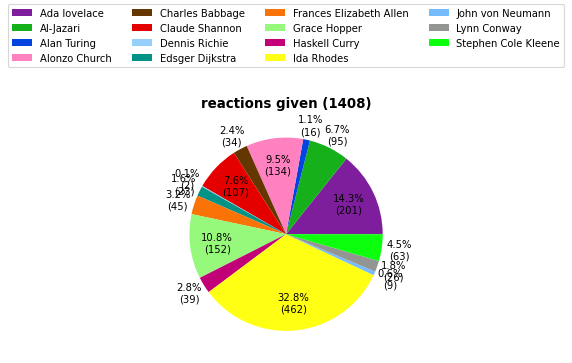

In [19]:
# Here we make stats about who gives reactions
reactions_stats = ConversationStats(
    reactions_data['timestamp'], reactions_data['actor'],
    data={'reactions': reactions_data['has_reaction']})

react_df = reactions_stats.sum(groups=None, timespan=None)
fig, axs = pie_plot(react_df, dpi=80)
_ = axs[0, 0].set_title(f"reactions given ({react_df['reactions'].sum()})",
                        y=1., pad=5, fontweight='bold')

## <a name="media_info"></a>Extracting media info

Informations relative to the medias published in the conversation can be obtained with `Conversation.media_info`. This returns a list of `NamedTuple` with relevant info: media type, sender, conversation name, file path and publication timestamp.

In [20]:
media_info = conv.media_info(['photos'])
media_info[:3]

[MediaInfo(media_type='photo', conv_name='conversation1_bhmqhe56cg', sender='Grace Hopper', uri='messages/inbox/conversation1_bhmqhe56cg/photos/224788901_2362450767254173_8587861743830743026_n_2862457170580507.jpg', timestamp=1483282638),
 MediaInfo(media_type='photo', conv_name='conversation1_bhmqhe56cg', sender='Grace Hopper', uri='messages/inbox/conversation1_bhmqhe56cg/photos/59009878_10153320063304375_1557865147_n_40153600763304375.jpg', timestamp=1483282638),
 MediaInfo(media_type='photo', conv_name='conversation1_bhmqhe56cg', sender='Charles Babbage', uri='messages/inbox/conversation1_bhmqhe56cg/photos/436242145_708685903681168_5751970373501785447_n_771685906347885.jpg', timestamp=1483282957)]

## <a name="filtering"></a>Filtering conversation messages

There is the possibility to filter the conversation messages, to yield a new `Conversation` instance, with the `filter_by` method. The available filters are:
- `timeframe`: Select messages which post date (`timestamp`) is in the timeframe.
- `participants` : Select messages sent by any of `participants`.
- `items` : Select messages if they have at least one non-empty attribute (eg photos, videos, etc) among `items`.
- `content_pattern` : Select messages if their `content` matches a regex pattern.

To do pattern matching with casefolded content and/or with diacritics removed, the method `match_pattern` is available.

In [21]:
pattern = r"they"
conv.filter_by(items={'photos'}, content_pattern=pattern)

MessengerConversation(
    messages=[Message(sender='Haskell Curry',
        timestamp=1492112434.293,
        content='they hot distance of off about do of union often they of of him man of they she very work could off of of design of oil future they strap she',
        photos=[{'uri': 'messages/inbox/conversation1_bhmqhe56cg/photos/323983958_476302114268703_2686348971644145406_n_476302171635310.jpg', 'timestamp': 1492112434}])],
    participants={'Haskell Curry'},
    name='filt_conversation1_bhmqhe56cg',
    title='Messenger conversation 1')